In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import pandas as pd
import os
import sys

PROJECT_PATH = os.path.abspath(
    os.path.join(os.path.dirname('__file__'), '..'))
sys.path.append(PROJECT_PATH)


from modules.data_loaders.base_line_loaders import load_cifar10, load_hits
from transformations import Transformer
from models.encoders_decoders import conv_encoder, conv_decoder
from utils import save_roc_pr_curve_data, get_class_name_from_index, get_channels_axis

LARGE_DATASET_NAMES = ['cats-vs-dogs', 'hits']
dataset_name, single_class_ind, subsample = ('hits', 1, True)

if dataset_name=='cifar10':
  (x_train, y_train), (x_test, y_test) = load_cifar10()
if dataset_name=='hits':
  (x_train, y_train), (x_test, y_test) = load_hits()
  
if subsample:
  (x_train, y_train) = (x_train[:100], y_train[:100])

transformer = Transformer(8, 8)

# get inliers of specific class
x_train_task = x_train[y_train.flatten() == single_class_ind]
# [0_i, ..., (N_transforms-1)_i, ..., ..., 0_N_samples, ...,
# (N_transforms-1)_N_samples] shape: (N_transforms*N_samples,)
transformations_inds = np.tile(np.arange(transformer.n_transforms), len(x_train_task))
x_train_task_transformed = transformer.transform_batch(np.repeat(x_train_task, transformer.n_transforms, axis=0),
                                                       transformations_inds)

Using TensorFlow backend.


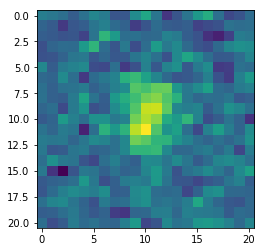

In [9]:
import matplotlib.pyplot as plt
plt.imshow(x_train_task_transformed[1*72+0][...,0])

In [10]:
n, k = (10, 4)
from models.wide_residual_network import create_wide_residual_network
mdl1 = create_wide_residual_network((x_train.shape[1:]), transformer.n_transforms, n, k)
mdl2 = create_wide_residual_network((21,21,1), transformer.n_transforms, n, k)

In [11]:
mdl1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 21, 21, 1)    0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 21, 21, 16)   144         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 21, 21, 16)   64          conv2d_21[0][0]                  
__________________________________________________________________________________________________
activation_17 (Activation)      (None, 21, 21, 16)   0           batch_normalization_15[0][0]     
__________________________________________________________________________________________________
conv2d_22 

In [12]:
mdl2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 21, 21, 1)    0                                            
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 21, 21, 16)   144         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 21, 21, 16)   64          conv2d_31[0][0]                  
__________________________________________________________________________________________________
activation_25 (Activation)      (None, 21, 21, 16)   0           batch_normalization_22[0][0]     
__________________________________________________________________________________________________
conv2d_32 

In [3]:
n_channels = x_train.shape[get_channels_axis()]
input_side = x_train.shape[2]  # channel side will always be at shape[2]
enc = conv_encoder(input_side, n_channels)
enc.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 21, 21, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 11, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 128)         73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 6, 6, 128)         512       
_________________________________________________________________
acti

In [5]:
dec = conv_decoder(input_side, n_channels)
dec.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2304)              592128    
_________________________________________________________________
batch_normalization_7 (Batch (None, 2304)              9216      
_________________________________________________________________
activation_8 (Activation)    (None, 2304)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 3, 3, 256)         0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 6, 6, 128)         295040    
_________________________________________________________________
batch_normalization_8 (Batch (None, 6, 6, 128)         512       
__________